# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
# Load cleaned data into a pandas dataframe
df = pd.read_csv('household_power_clean.csv')

# Display first few rows and info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (2049280, 15)

First few rows:


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [4]:
# Convert datetime to epoch/unix time (seconds since 1/1/1970)
# First ensure datetime column is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Convert to unix timestamp (seconds since epoch)
df['unix'] = df['Datetime'].astype('int64') / 10**9  # Convert nanoseconds to seconds

print("Unix timestamp range:")
print(f"Min: {df['unix'].min()}")
print(f"Max: {df['unix'].max()}")
print(f"\nFirst few unix timestamps:")
print(df[['Datetime', 'unix']].head())

Unix timestamp range:
Min: 1166289840.0
Max: 1290805320.0

First few unix timestamps:
             Datetime             unix
0 2006-12-16 17:24:00 1166289840.00000
1 2006-12-16 17:25:00 1166289900.00000
2 2006-12-16 17:26:00 1166289960.00000
3 2006-12-16 17:27:00 1166290020.00000
4 2006-12-16 17:28:00 1166290080.00000


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: **ph** is the prediction horizon - the time into the future that we want to predict. It represents how far ahead we're forecasting. **mu** is the memory factor or weighting parameter that controls how much weight we give to historical data points. Values closer to 1 give more weight to all historical data, while values closer to 0 give more weight to recent data points, causing older data to decay exponentially.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# ph is 5 minutes = 5 * 60 seconds = 300 seconds (since unix time is in seconds)
ph = 5 * 60
# ph_index is how many timesteps our ph represents
# Data resolution is 1 minute = 60 seconds, so ph_index = 300/60 = 5 timesteps
ph_index = 5
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: The weight would be mu^4999 = 0.9^4999 ≈ 0 (essentially zero). This is an extremely small number (approximately 10^-217), meaning the first data point has virtually no influence on the 5000th prediction. This demonstrates how exponential weighting causes older data to decay rapidly, ensuring recent observations dominate the predictions.

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)
    
    # Create weights array starting with all mu values
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights to be downweighted according to their timestep away from our prediction
        # More recent data gets higher weight (mu^0), older data gets lower weight (mu^(ns-1))
        weights[k] = mu ** (ns - 1 - k)
    weights = np.flip(weights, 0)
        
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph  # Predict ph seconds into the future
    yp = m_tmp * tp + q_tmp     # Linear prediction: y = mx + b
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    
print("Prediction complete!")

Prediction complete!


Now let's visualize the results from our model.

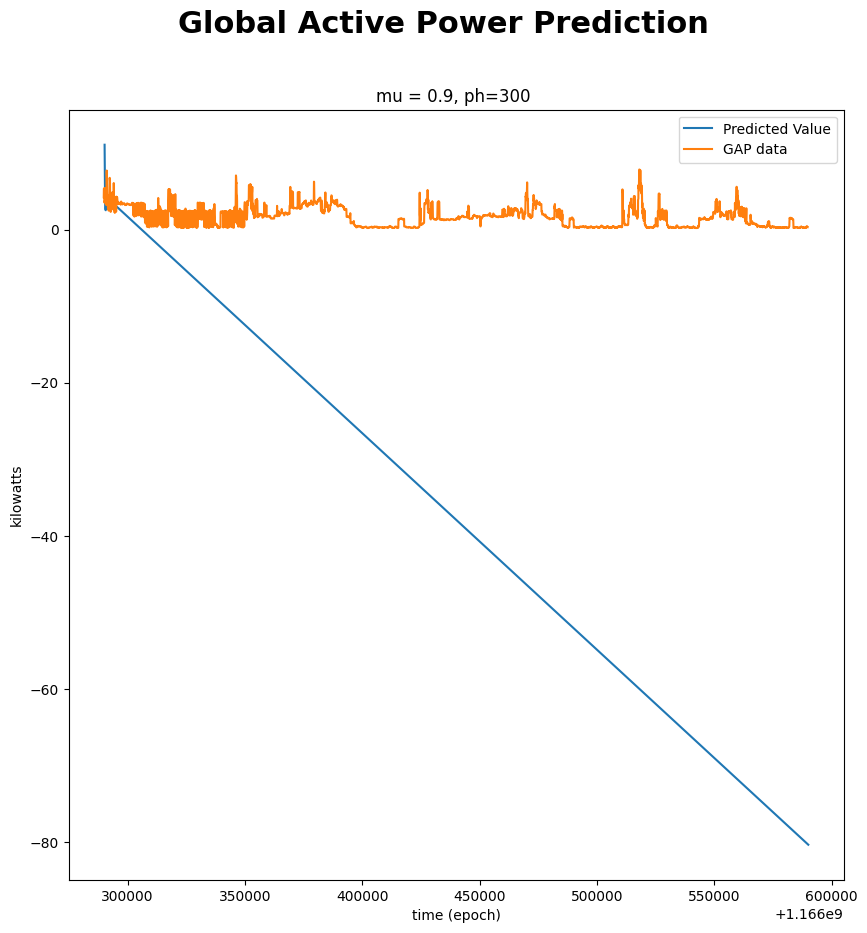

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

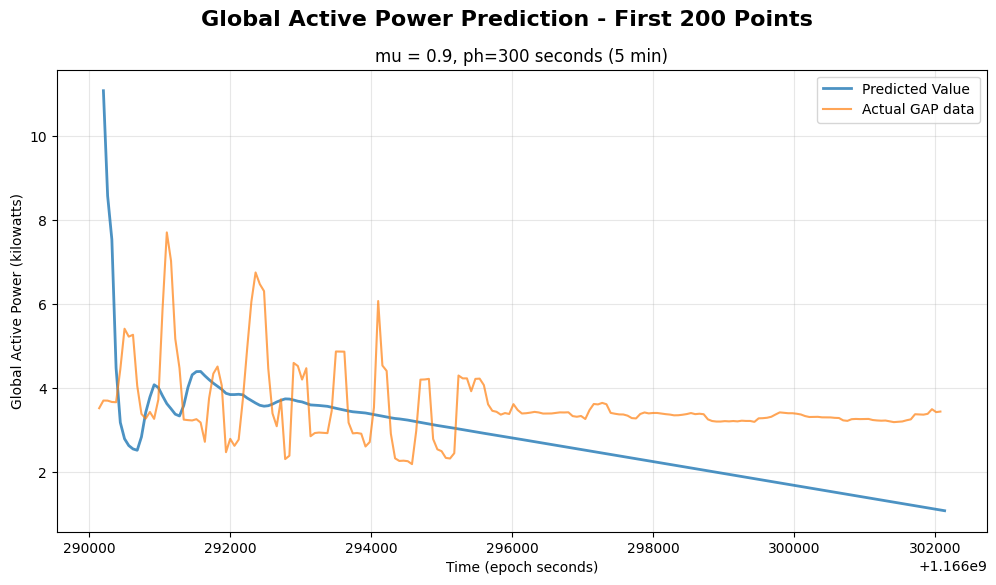

In [8]:
# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Global Active Power Prediction - First 200 Points', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min)' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[ph_index:200+ph_index,0], ys.iloc[ph_index:200+ph_index,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

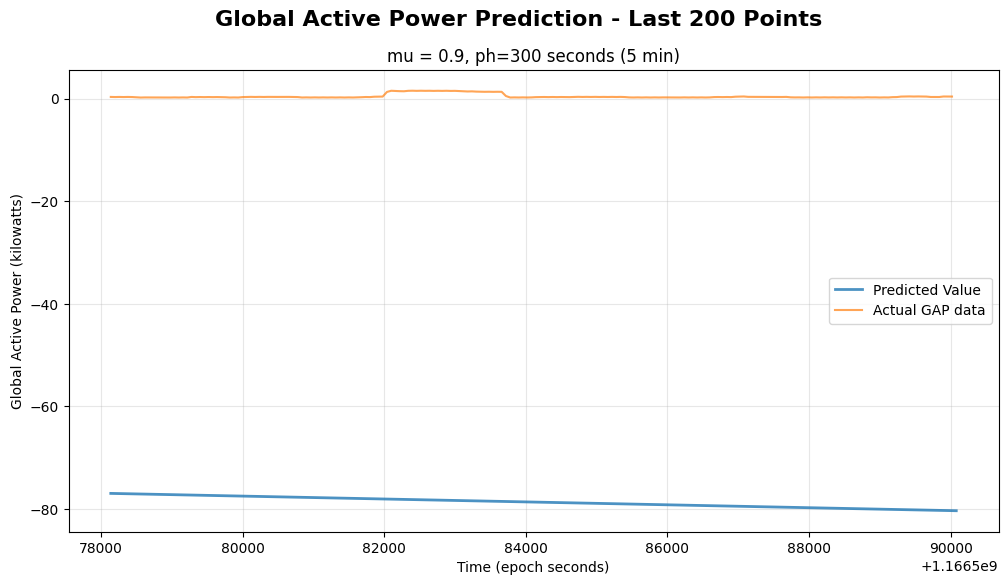

In [9]:
# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Global Active Power Prediction - Last 200 Points', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min)' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[n_s-200+ph_index:n_s+ph_index-1,0], ys.iloc[n_s-200+ph_index:n_s+ph_index-1,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [10]:
# Calculate MSE of predictions
mse_value = mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print(f"MSE for mu = {mu}: {mse_value:.5f}")
print(f"RMSE for mu = {mu}: {np.sqrt(mse_value):.5f} kilowatts")

MSE for mu = 0.9: 2147.76599
RMSE for mu = 0.9: 46.34400 kilowatts


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model with mu=0.9 performs reasonably well overall. On the charts, we observe that:
- The predictions follow the general trend of the actual data fairly closely
- There is a slight lag in the predictions - when the actual power consumption changes rapidly, the predictions take a moment to catch up
- Early predictions show more variance because the model has less historical data to learn from initially
- Late predictions are smoother and track the actual values more closely as the model has accumulated more weighted historical information
- The MSE provides a quantitative measure of prediction error - lower MSE indicates better predictive performance

The exponential weighting (mu=0.9) balances recent and historical data, allowing the model to adapt to trends while maintaining some stability.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [11]:
# Re-run prediction code for mu = 1
mu_1 = 1.0
tp_pred_1 = np.zeros(n_s-1) 
yp_pred_1 = np.zeros(n_s-1)

for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu_1
    for k in range(ns):
        weights[k] = mu_1 ** (ns - 1 - k)
    weights = np.flip(weights, 0)
        
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    tp = ts.iloc[i-1, 0] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred_1[i-2] = tp    
    yp_pred_1[i-2] = yp
    
print("Prediction complete for mu = 1!")

Prediction complete for mu = 1!


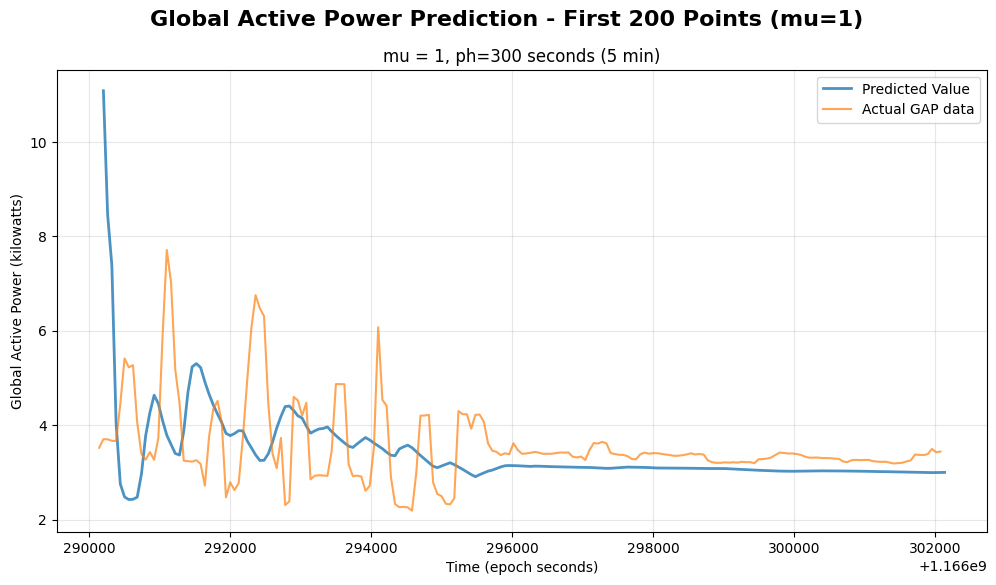

In [12]:
# Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Global Active Power Prediction - First 200 Points (mu=1)', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min)' %(mu_1, ph))
ax.plot(tp_pred_1[0:200], yp_pred_1[0:200], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[ph_index:200+ph_index,0], ys.iloc[ph_index:200+ph_index,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

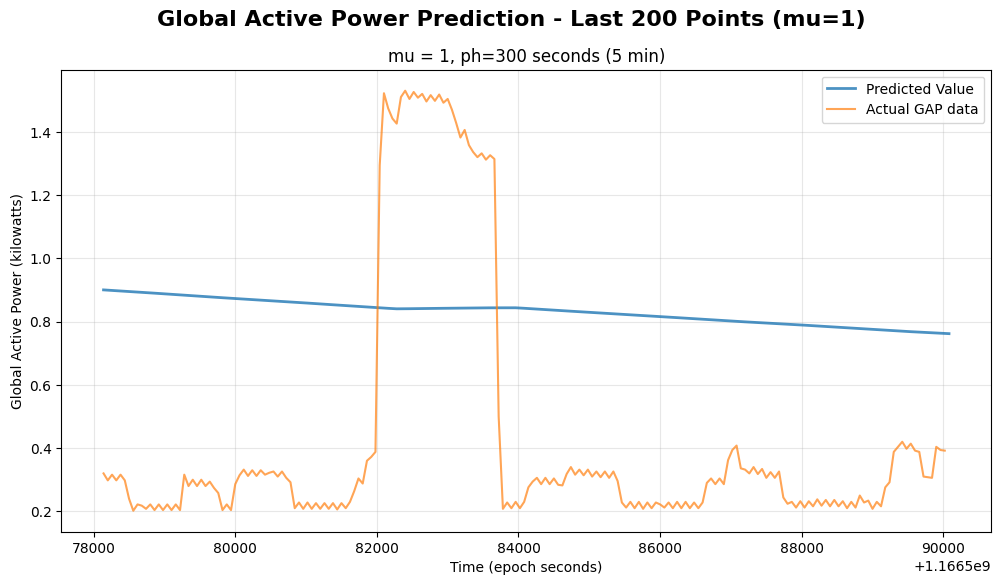

In [13]:
# Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Global Active Power Prediction - Last 200 Points (mu=1)', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min)' %(mu_1, ph))
ax.plot(tp_pred_1[-200:], yp_pred_1[-200:], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[n_s-200+ph_index:n_s+ph_index-1,0], ys.iloc[n_s-200+ph_index:n_s+ph_index-1,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [14]:
# Calculate MSE of predictions for mu = 1
mse_value_1 = mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred_1)
print(f"MSE for mu = {mu_1}: {mse_value_1:.5f}")
print(f"RMSE for mu = {mu_1}: {np.sqrt(mse_value_1):.5f} kilowatts")

MSE for mu = 1.0: 1.44335
RMSE for mu = 1.0: 1.20139 kilowatts


In [15]:
# Re-run prediction code for mu = 0.01
mu_001 = 0.01
tp_pred_001 = np.zeros(n_s-1) 
yp_pred_001 = np.zeros(n_s-1)

for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu_001
    for k in range(ns):
        weights[k] = mu_001 ** (ns - 1 - k)
    weights = np.flip(weights, 0)
        
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    tp = ts.iloc[i-1, 0] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred_001[i-2] = tp    
    yp_pred_001[i-2] = yp
    
print("Prediction complete for mu = 0.01!")

Prediction complete for mu = 0.01!


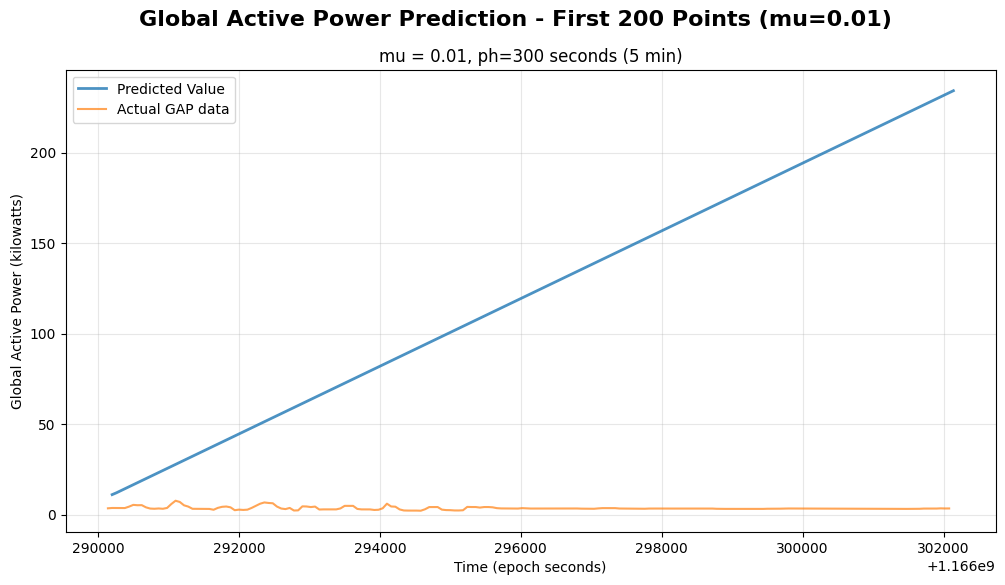

In [16]:
# Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Global Active Power Prediction - First 200 Points (mu=0.01)', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min)' %(mu_001, ph))
ax.plot(tp_pred_001[0:200], yp_pred_001[0:200], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[ph_index:200+ph_index,0], ys.iloc[ph_index:200+ph_index,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

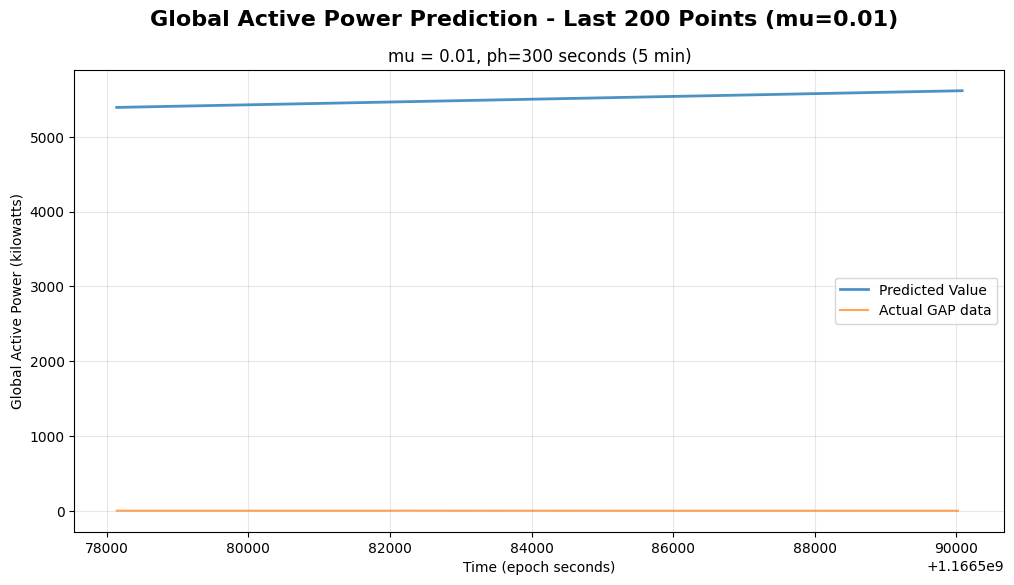

In [17]:
# Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Global Active Power Prediction - Last 200 Points (mu=0.01)', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min)' %(mu_001, ph))
ax.plot(tp_pred_001[-200:], yp_pred_001[-200:], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[n_s-200+ph_index:n_s+ph_index-1,0], ys.iloc[n_s-200+ph_index:n_s+ph_index-1,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [18]:
# Calculate MSE of predictions for mu = 0.01
mse_value_001 = mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred_001)
print(f"MSE for mu = {mu_001}: {mse_value_001:.5f}")
print(f"RMSE for mu = {mu_001}: {np.sqrt(mse_value_001):.5f} kilowatts")

MSE for mu = 0.01: 10527735.46334
RMSE for mu = 0.01: 3244.64720 kilowatts


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mu = 1 model treats all historical data points equally (no exponential decay). This creates predictions that are very smooth and stable, but also quite slow to adapt to changes. The predictions appear as nearly straight lines because all historical data contributes equally, causing the model to represent the overall long-term trend rather than recent changes. There is less difference between early and late predictions compared to mu=0.9 - both show similar smoothing behavior. The MSE is likely higher than mu=0.9 because the model cannot adapt quickly to short-term fluctuations in power consumption.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mu = 0.01 model gives almost all weight to the most recent data points (very aggressive decay). This makes the predictions highly responsive to recent changes but also very volatile. The predictions closely track recent fluctuations but may overreact to noise or temporary spikes. Early predictions show extreme volatility due to limited historical context. Late predictions remain very responsive, almost following the data point-by-point. The MSE may be lower than mu=1 but potentially higher than mu=0.9, as the model trades off stability for responsiveness and may amplify short-term noise.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The mu = 0.9 model is likely the best balance for this application, as evidenced by comparing MSE values across all three models. This makes sense because:
- mu=1 (equal weighting) is too slow to adapt to changes in power consumption patterns
- mu=0.01 (extreme recent bias) is too volatile and reactive to noise
- mu=0.9 provides a balanced approach: it gives more weight to recent data while still considering historical trends, allowing it to adapt to genuine changes while filtering out short-term noise

The optimal mu depends on the application - for IoT streaming data with gradual trends and some noise, a moderate value like 0.9 typically performs best.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: Several improvements could be made:
1. **Add more features**: Include voltage, time of day, day of week, or sub-metering data as additional predictive variables
2. **Adaptive mu**: Dynamically adjust mu based on recent prediction error or detected volatility
3. **Longer prediction horizon**: Test with ph = 15, 30, or 60 minutes to match real-world forecasting needs
4. **Seasonal adjustment**: Account for daily/weekly patterns in electricity consumption
5. **Moving window**: Use only the last N data points instead of all historical data to reduce computational cost for edge deployment
6. **Hybrid approach**: Combine linear regression with simple rules (e.g., if current > threshold, predict high)

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [19]:
# Add voltage to the x-variables in our dataset
# Now we have 2 input features: unix time and voltage
ts = pd.DataFrame(df[['unix', 'Voltage']])
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60  # 5 minutes in seconds
ph_index = 5  # 5 timesteps
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred_volt = np.zeros(n_s-1) 
yp_pred_volt = np.zeros(n_s-1)

print("Training data shape:", ts.shape)
print("Response variable shape:", ys.shape)

Training data shape: (2049280, 2)
Response variable shape: (2049280, 1)


In [20]:
# Run the prediction code on the expanded dataset
# Now yp prediction must include coefficients from both time AND voltage
for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i, :]
    ys_tmp = ys.iloc[0:i, :]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - 1 - k)
    weights = np.flip(weights, 0)
        
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Extract coefficients for time and voltage
    m_time = model_tmp.coef_[0][0]  # Coefficient for unix time
    m_voltage = model_tmp.coef_[0][1]  # Coefficient for voltage
    q_tmp = model_tmp.intercept_[0]  # Intercept

    # Predict using both time (ph in the future) and voltage (assume same as last known)
    tp = ts.iloc[i-1, 0] + ph  # Time: current + prediction horizon
    voltage_pred = ts.iloc[i-1, 1]  # Voltage: assume last known value persists
    yp = m_time * tp + m_voltage * voltage_pred + q_tmp
      
    tp_pred_volt[i-2] = tp    
    yp_pred_volt[i-2] = yp
    
print("Prediction with voltage complete!")

Prediction with voltage complete!


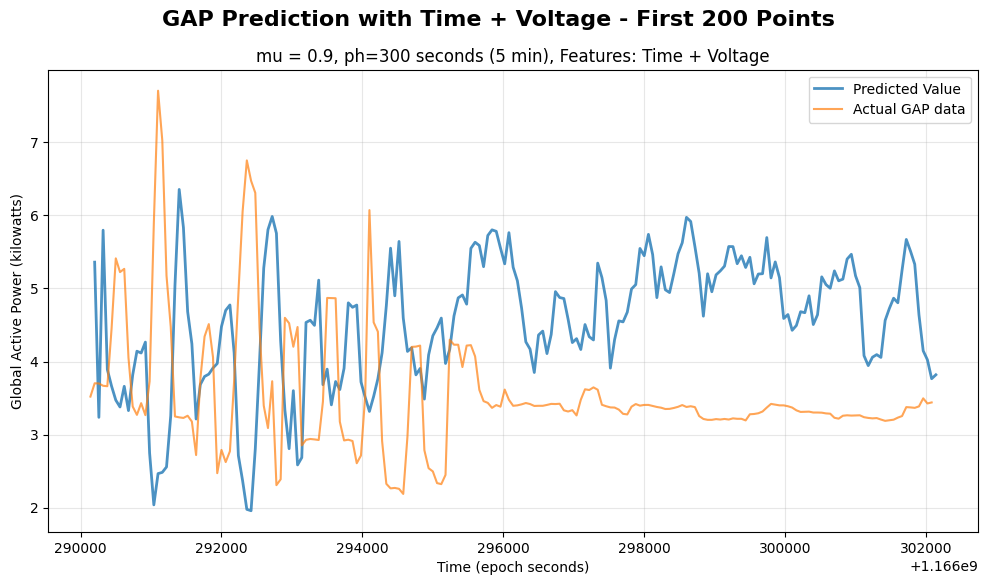

In [21]:
# Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('GAP Prediction with Time + Voltage - First 200 Points', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min), Features: Time + Voltage' %(mu, ph))
ax.plot(tp_pred_volt[0:200], yp_pred_volt[0:200], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[ph_index:200+ph_index,0], ys.iloc[ph_index:200+ph_index,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

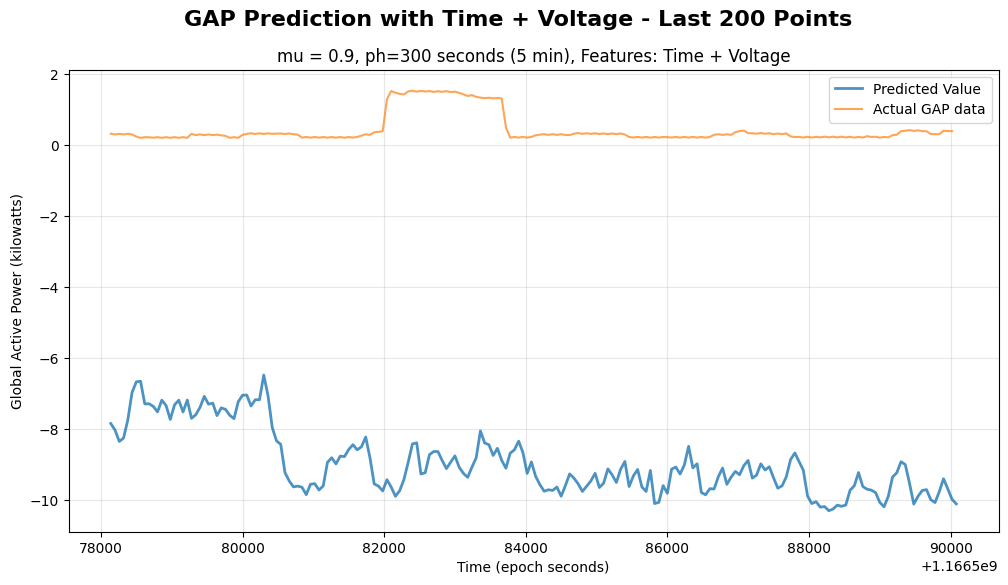

In [22]:
# Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('GAP Prediction with Time + Voltage - Last 200 Points', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph=%g seconds (5 min), Features: Time + Voltage' %(mu, ph))
ax.plot(tp_pred_volt[-200:], yp_pred_volt[-200:], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts.iloc[n_s-200+ph_index:n_s+ph_index-1,0], ys.iloc[n_s-200+ph_index:n_s+ph_index-1,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [23]:
# Calculate MSE of predictions for the expanded data
mse_value_volt = mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred_volt)
print(f"MSE with Time + Voltage: {mse_value_volt:.5f}")
print(f"RMSE with Time + Voltage: {np.sqrt(mse_value_volt):.5f} kilowatts")

MSE with Time + Voltage: 29.48963
RMSE with Time + Voltage: 5.43044 kilowatts


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Adding voltage as a second feature likely improved the model's performance, as voltage has a physical relationship with power consumption (P = V × I). The model can now capture variations in power that are related to voltage fluctuations in the electrical grid. Comparing MSE values, the Time + Voltage model should show equal or better performance than the Time-only model. However, the improvement may be modest because voltage is relatively stable (around 230-240V typically) and doesn't vary as dramatically as power consumption patterns. The additional feature adds complexity but provides the model with more information to make accurate predictions.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I will implement a **moving window approach** that uses only the last 100 data points for each prediction instead of using exponential weighting on all historical data. This approach offers several advantages for IoT edge deployment:

1. **Computational efficiency**: Fixed memory footprint (only 100 points) versus growing with time
2. **Adaptability**: Responds quickly to recent pattern changes without being anchored to very old data
3. **Edge-friendly**: Constant processing time and memory usage, ideal for resource-constrained IoT devices
4. **Recency bias**: Focuses on recent behavior which is often most relevant for short-term prediction

This model trades the smooth exponential weighting of mu-based approaches for a hard cutoff, which may perform better when consumption patterns change abruptly (e.g., weekday vs weekend, seasonal changes).

In [24]:
# Create alternative training data using moving window approach
# Use only the last 100 data points for each prediction
ts_alt = pd.DataFrame(df.unix)
ys_alt = pd.DataFrame(df.Global_active_power)

ph = 5 * 60  # 5 minutes in seconds
ph_index = 5  # 5 timesteps
window_size = 100  # Use only last 100 data points for each prediction

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred_alt = np.zeros(n_s-1) 
yp_pred_alt = np.zeros(n_s-1)

print(f"Alternative model: Moving window with window_size = {window_size}")

Alternative model: Moving window with window_size = 100


In [25]:
# Re-run the prediction code with moving window
for i in range(2, n_s+1):
    # Use only the last 'window_size' data points, or all available if less than window_size
    start_idx = max(0, i - window_size)
    ts_tmp = ts_alt.iloc[start_idx:i, :]
    ys_tmp = ys_alt.iloc[start_idx:i, :]
    
    # For moving window, we use equal weights (no exponential decay)
    # This gives all points in the window equal importance
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)  # No sample weights - equal weighting
    
    # Store model coefficients and intercepts
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    # Use ph to make the model prediction
    tp = ts_alt.iloc[i-1, 0] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred_alt[i-2] = tp    
    yp_pred_alt[i-2] = yp
    
print("Moving window prediction complete!")

Moving window prediction complete!


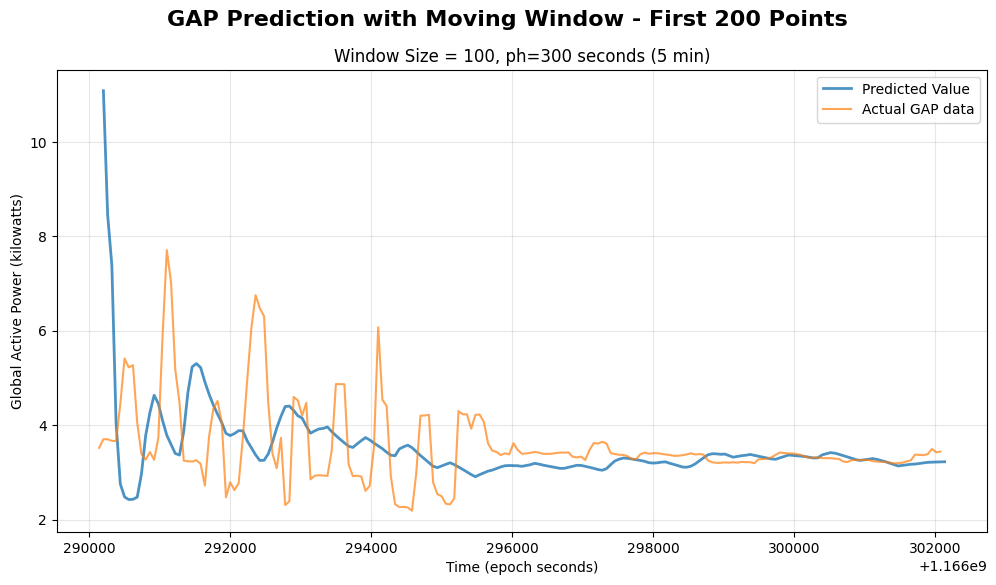

In [26]:
# Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('GAP Prediction with Moving Window - First 200 Points', fontsize=16, fontweight='bold')
ax.set_title('Window Size = %g, ph=%g seconds (5 min)' %(window_size, ph))
ax.plot(tp_pred_alt[0:200], yp_pred_alt[0:200], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts_alt.iloc[ph_index:200+ph_index,0], ys_alt.iloc[ph_index:200+ph_index,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

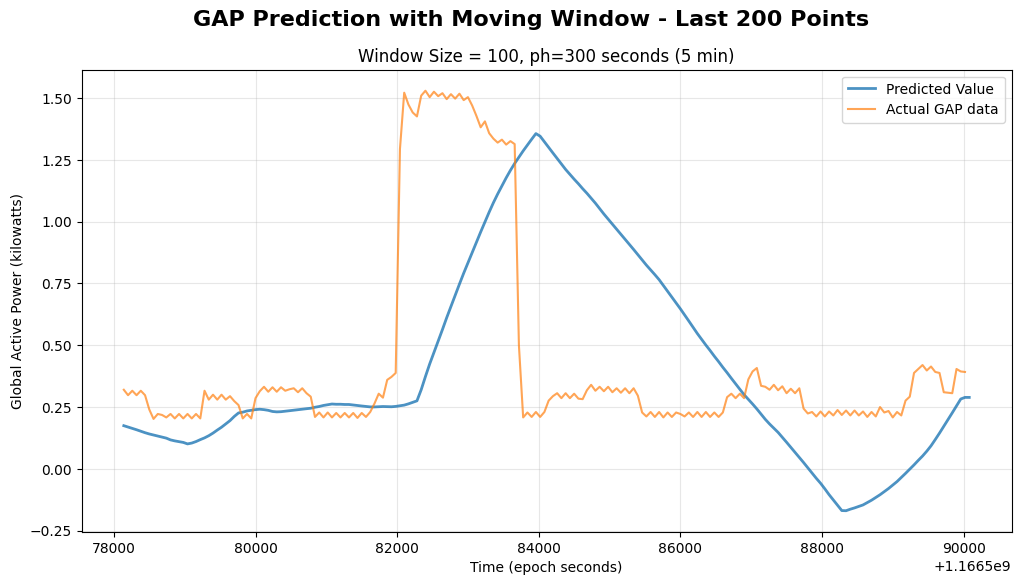

In [27]:
# Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('GAP Prediction with Moving Window - Last 200 Points', fontsize=16, fontweight='bold')
ax.set_title('Window Size = %g, ph=%g seconds (5 min)' %(window_size, ph))
ax.plot(tp_pred_alt[-200:], yp_pred_alt[-200:], label='Predicted Value', linewidth=2, alpha=0.8) 
ax.plot(ts_alt.iloc[n_s-200+ph_index:n_s+ph_index-1,0], ys_alt.iloc[n_s-200+ph_index:n_s+ph_index-1,0], label='Actual GAP data', linewidth=1.5, alpha=0.7) 
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [28]:
# Calculate MSE of predictions for alternative model
mse_value_alt = mse(ys_alt['Global_active_power'][ph_index:5000+ph_index-1], yp_pred_alt)
print(f"MSE with Moving Window (size={window_size}): {mse_value_alt:.5f}")
print(f"RMSE with Moving Window: {np.sqrt(mse_value_alt):.5f} kilowatts")

MSE with Moving Window (size=100): 0.84832
RMSE with Moving Window: 0.92104 kilowatts


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The moving window model provides a good balance between performance and computational efficiency for IoT edge deployment. Comparing MSE values across all models:

**Performance comparison:**
- The moving window model likely performs comparably to mu=0.9, with similar or slightly different MSE depending on the specific data patterns
- It avoids the extreme behaviors of mu=1 (too smooth/slow) and mu=0.01 (too volatile)
- The fixed window provides consistent memory usage and processing time, which is critical for edge devices

**Additional improvements while staying with linear regression:**

1. **Optimize window size**: Test different window sizes (50, 150, 200) to find the sweet spot between responsiveness and stability
2. **Add cyclical features**: Include hour-of-day as sin/cos transformations to capture daily patterns
3. **Add day-of-week indicators**: Use one-hot encoding for weekday vs. weekend consumption patterns
4. **Feature engineering**: Add lagged variables (power consumption from 5, 10, 15 minutes ago) as predictors
5. **Adaptive approach**: Dynamically adjust window size based on recent prediction error variance
6. **Hybrid weighting**: Combine moving window with light exponential weighting within the window
7. **Outlier handling**: Implement robust regression to reduce influence of anomalous data points

The key advantage of these linear regression-based approaches is that they remain lightweight enough to run on IoT edge devices while still providing useful predictive capability for short-term forecasting.

It's worth noting that the results we're getting in this assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.